In [14]:
import sys
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
sys.path.append('..')
print(sys.path)
from nlp_pipeline.feature_extraction import FeatureExtractor
from nlp_pipeline.preprocess_text import TextPreprocessor
from model.evaluate_model import ModelEvaluator
from model.train_baseline import BaselineTrainer
from interpretation.lime_interpreter import LimeTextInterpreter
from interpretation.shap_interpreter import ShapInterpreter
from nlp_pipeline.back_translator import BackTranslationAugmentor
from nlp_pipeline.embedding_oversample import EmbeddingOversampler

['d:\\aco\\research\\Asd-classification\\notebook', 'c:\\Users\\MufliDevs\\anaconda3\\python312.zip', 'c:\\Users\\MufliDevs\\anaconda3\\DLLs', 'c:\\Users\\MufliDevs\\anaconda3\\Lib', 'c:\\Users\\MufliDevs\\anaconda3', '', 'c:\\Users\\MufliDevs\\anaconda3\\Lib\\site-packages', 'c:\\Users\\MufliDevs\\anaconda3\\Lib\\site-packages\\win32', 'c:\\Users\\MufliDevs\\anaconda3\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\MufliDevs\\anaconda3\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\MufliDevs\\anaconda3\\Lib\\site-packages\\setuptools\\_vendor', '..', '..', '..']


Load dataset + Augmented

In [ ]:
df = df = pd.read_csv('../data/feature/merged_final.csv', encoding='latin1')
columns = ['label', 'transcription', 'total_words', 'unique_words', 'num_sentences',
                   'stopwords', 'num_adjectives', 'num_nouns', 'num_verbs', 'num_adverbs',
                   'type_token_ratio', 'avg_words_per_sentence']
df = df[columns]
augmentor = BackTranslationAugmentor()
df_augmented = augmentor.augment_dataframe(df)
print(df_augmented.head)
df_augmented.to_csv('../data/feature/1_augmented.csv', index=False)

Preprocessing text

In [2]:
df = df = pd.read_csv('../data/feature/combined_augmented_asd.csv', encoding='latin1')
text_preprocessor = TextPreprocessor()
df['clean_text'] = df['transcription'].apply(text_preprocessor.preprocess)
df[['transcription', 'clean_text']].head()

,transcription,clean_text
0,Tunjuk kaka coba,tunjuk kaka coba
1,Inii!,ini
2,Siapa namamu?,siapa nama
3,Iyaaaa?,
4,Kenalan duluu!,kenal duluu


In [ ]:
df['label'].value_counts()
df['label'].value_counts()

Ekstraksi fitur with TFIDF

In [ ]:
extractor = FeatureExtractor()
X = extractor.fit_transform_tfidf(df['clean_text'])
y = df['label'].values
print(X.shape, y.shape)

Oversampling with TFIDF

In [ ]:
X_dense = extractor.fit_transform_tfidf(df['clean_text']).toarray()

ling_cols = extractor.linguistic_cols
X_ling = df[ling_cols].values

y = (df['label'].str.upper().str.strip() == 'ASD').astype(int).values

oversampler = EmbeddingOversampler()
X_embed_bal, X_ling_bal, y_bal = oversampler.oversample(X_dense, X_ling, y)


Ekstraksi fitur with IndoBERT

In [ ]:
extractor = FeatureExtractor()
X = extractor.encode_series_bert(df['clean_text'])
y = (df['label'].str.upper().str.strip() == 'ASD').astype(int).values
ling_cols = extractor.linguistic_cols
X_ling = df[ling_cols].values
oversampler = EmbeddingOversampler()
X_embed_bal, X_ling_bal, y_bal = oversampler.oversample(X, X_ling, y)

print(X_embed_bal.shape, y.shape)

SVC WITH 5 FOLD

In [4]:
trainer = BaselineTrainer()

evaluator = ModelEvaluator(model_type='svm',pos_label=1)

results = evaluator.cross_validate_oversample_with_confusionmatrix(X_embed_bal,y_bal)


[Oversampled] Fold 1
              precision    recall  f1-score   support

           0      0.941     0.805     0.868       930
           1      0.830     0.949     0.886       930

    accuracy                          0.877      1860
   macro avg      0.885     0.877     0.877      1860
weighted avg      0.885     0.877     0.877      1860

Confusion Matrix:
 [[749 181]
 [ 47 883]]
Confusion Matrix (Fold 1):
[[749 181]
 [ 47 883]]

[Oversampled] Fold 2
              precision    recall  f1-score   support

           0      0.948     0.820     0.880       930
           1      0.842     0.955     0.895       929

    accuracy                          0.888      1859
   macro avg      0.895     0.888     0.887      1859
weighted avg      0.895     0.888     0.887      1859

Confusion Matrix:
 [[763 167]
 [ 42 887]]
Confusion Matrix (Fold 2):
[[763 167]
 [ 42 887]]

[Oversampled] Fold 3
              precision    recall  f1-score   support

           0      0.940     0.828     0.8

USE THIS IF YOU NOT USING BERT

In [ ]:
final_model = trainer.train(X_embed_bal, y_bal)

lime_interpreter = LimeTextInterpreter(
    model=final_model,
    vectorizer=extractor.get_tfidf_vectorizer(),
    class_names=['NON ASD', 'ASD']
)

asd_samples = df[df['label'] == 'ASD'].sample(n=12, random_state=42)
non_asd_samples = df[df['label'] == 'NON ASD'].sample(n=12, random_state=42)
lime_samples = pd.concat([asd_samples, non_asd_samples]).reset_index(drop=True)

lime_interpreter.save_lime_explanation_to_csv(lime_samples,"../reports/lime_results.csv")

In [ ]:
final_model = BaselineTrainer('svm').train(X_embed_bal,y_bal)
interpreter = ShapInterpreter(model=final_model)
sampled_df = df.sample(n=100, random_state=42)
texts = sampled_df['clean_text'].tolist()
labels = sampled_df['label'].tolist()

shap_values = interpreter.explain(texts)
interpreter.save_shap_explanations_to_csv(
    shap_values=shap_values,
    texts=texts,
    output_path="../reports/shap_results_SVM_oversample+bert.csv",
    true_labels=labels
)

LINEAR REGRETION WITH 5 FOLD

In [6]:
trainer = BaselineTrainer()
evaluator = ModelEvaluator(pos_label=1)

results = evaluator.cross_validate_oversample_with_confusionmatrix(X_embed_bal,y_bal)


[Oversampled] Fold 1
              precision    recall  f1-score   support

           0      0.905     0.801     0.850       930
           1      0.822     0.916     0.866       930

    accuracy                          0.859      1860
   macro avg      0.863     0.859     0.858      1860
weighted avg      0.863     0.859     0.858      1860

Confusion Matrix:
 [[745 185]
 [ 78 852]]
Confusion Matrix (Fold 1):
[[745 185]
 [ 78 852]]

[Oversampled] Fold 2
              precision    recall  f1-score   support

           0      0.928     0.810     0.865       930
           1      0.831     0.938     0.881       929

    accuracy                          0.874      1859
   macro avg      0.880     0.874     0.873      1859
weighted avg      0.880     0.874     0.873      1859

Confusion Matrix:
 [[753 177]
 [ 58 871]]
Confusion Matrix (Fold 2):
[[753 177]
 [ 58 871]]

[Oversampled] Fold 3
              precision    recall  f1-score   support

           0      0.912     0.817     0.8

In [ ]:
final_model = trainer.train(X, y)

lime_interpreter = LimeTextInterpreter(
    model=final_model,
    vectorizer=extractor.get_tfidf_vectorizer(),
    class_names=['NON ASD', 'ASD']
)

asd_samples = df[df['label'] == 'ASD'].sample(n=12, random_state=42)
non_asd_samples = df[df['label'] == 'NON ASD'].sample(n=12, random_state=42)
lime_samples = pd.concat([asd_samples, non_asd_samples]).reset_index(drop=True)

lime_interpreter.save_lime_explanation_to_csv(lime_samples,"../reports/lime_results_LOGRES.csv")

SVM WITH 10 FOLD

In [5]:
trainer = BaselineTrainer()
evaluator = ModelEvaluator(model_type='svm', n_splits= 10, random_state=32,pos_label=1)

results = evaluator.cross_validate_oversample_with_confusionmatrix(X_embed_bal,y_bal)


[Oversampled] Fold 1
              precision    recall  f1-score   support

           0      0.967     0.822     0.888       465
           1      0.845     0.972     0.904       465

    accuracy                          0.897       930
   macro avg      0.906     0.897     0.896       930
weighted avg      0.906     0.897     0.896       930

Confusion Matrix:
 [[382  83]
 [ 13 452]]
Confusion Matrix (Fold 1):
[[382  83]
 [ 13 452]]

[Oversampled] Fold 2
              precision    recall  f1-score   support

           0      0.948     0.828     0.884       465
           1      0.847     0.955     0.898       465

    accuracy                          0.891       930
   macro avg      0.898     0.891     0.891       930
weighted avg      0.898     0.891     0.891       930

Confusion Matrix:
 [[385  80]
 [ 21 444]]
Confusion Matrix (Fold 2):
[[385  80]
 [ 21 444]]

[Oversampled] Fold 3
              precision    recall  f1-score   support

           0      0.945     0.854     0.8

In [ ]:
final_model = trainer.train(X, y)

lime_interpreter = LimeTextInterpreter(
    model=final_model,
    vectorizer=extractor.get_tfidf_vectorizer(),
    class_names=['NON ASD', 'ASD']
)

asd_samples = df[df['label'] == 'ASD'].sample(n=12, random_state=42)
non_asd_samples = df[df['label'] == 'NON ASD'].sample(n=12, random_state=42)
lime_samples = pd.concat([asd_samples, non_asd_samples]).reset_index(drop=True)

lime_interpreter.save_lime_explanation_to_csv(lime_samples,"../reports/lime_results_SVM10FOLD.csv")

In [ ]:
final_model = BaselineTrainer('svm').train(X,y)
interpreter = ShapInterpreter(model=final_model)
sampled_df = df.sample(n=100, random_state=42)
texts = sampled_df['clean_text'].tolist()
labels = sampled_df['label'].tolist()

shap_values = interpreter.explain(texts)
interpreter.save_shap_explanations_to_csv(
    shap_values=shap_values,
    texts=texts,
    output_path="../reports/shap_results_SVM_10_fold.csv",
    true_labels=labels
)

LINEAR REGRETION WITH 10 FOLD

In [8]:
trainer = BaselineTrainer()
evaluator = ModelEvaluator(n_splits= 10, random_state=32,pos_label=1)

results = evaluator.cross_validate_oversample_with_confusionmatrix(X_embed_bal,y_bal)


[Oversampled] Fold 1
              precision    recall  f1-score   support

           0      0.950     0.813     0.876       465
           1      0.836     0.957     0.893       465

    accuracy                          0.885       930
   macro avg      0.893     0.885     0.884       930
weighted avg      0.893     0.885     0.884       930

Confusion Matrix:
 [[378  87]
 [ 20 445]]
Confusion Matrix (Fold 1):
[[378  87]
 [ 20 445]]

[Oversampled] Fold 2
              precision    recall  f1-score   support

           0      0.933     0.776     0.847       465
           1      0.808     0.944     0.871       465

    accuracy                          0.860       930
   macro avg      0.871     0.860     0.859       930
weighted avg      0.871     0.860     0.859       930

Confusion Matrix:
 [[361 104]
 [ 26 439]]
Confusion Matrix (Fold 2):
[[361 104]
 [ 26 439]]

[Oversampled] Fold 3
              precision    recall  f1-score   support

           0      0.914     0.845     0.8

In [ ]:
final_model = BaselineTrainer('svm').train(X,y)
interpreter = ShapInterpreter(model=final_model)
sampled_df = df.sample(n=100, random_state=42)
texts = sampled_df['clean_text'].tolist()
labels = sampled_df['label'].tolist()

shap_values = interpreter.explain(texts)
interpreter.save_shap_explanations_to_csv(
    shap_values=shap_values,
    texts=texts,
    output_path="../reports/shap_results_Logres_10_fold.csv",
    true_labels=labels
)


In [ ]:
interpreter.visualize(shap_values= shap_values)

FUSION

In [ ]:
extractor = FeatureExtractor()
X = extractor.extract_fused_features_bert(df)
y = (df['label'].str.upper().str.strip() == 'ASD').astype(int).values
ling_cols = extractor.linguistic_cols
X_ling = df[ling_cols].values
oversampler = EmbeddingOversampler()
X_embed_bal, X_ling_bal, y_bal = oversampler.oversample(X, X_ling, y)

print(X_embed_bal.shape, y.shape)

Fusion with tfidf

In [3]:
extractor = FeatureExtractor()
X = extractor.extract_fused_features_tfidf(df, fit=True)
y = (df['label'].str.upper().str.strip() == 'ASD').astype(int).values
ling_cols = extractor.linguistic_cols
X_ling = df[ling_cols].values
oversampler = EmbeddingOversampler()
X_embed_bal, X_ling_bal, y_bal = oversampler.oversample(X, X_ling, y)

print(X_embed_bal.shape, y.shape)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

(9296, 5010) (8380,)


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [ ]:
evaluator = ModelEvaluator(model_type='svm', n_splits= 10, random_state=32)
results = evaluator.cross_validate_with_confusionmatrix(X, y)


Testing Model

In [ ]:
trainer = BaselineTrainer(model_type='svm')
model = trainer.train(X_embed_bal, y_bal)

new_text = "Apakah kamu suddah makan?"
clean_text = text_preprocessor.preprocess(new_text)
X_new = extractor.encode_series_bert([clean_text])
predicted_label = model.predict(X_new)[0]
print(f"Predicted label: {predicted_label}")

In [ ]:
new_text = "Apakah kamu sudah makan?"
clean_text = text_preprocessor.preprocess(new_text)
X_new = extractor.encode_series_bert([clean_text])
predicted_label = model.predict(X_new)[0]
print(f"Predicted label: {predicted_label}")

Bar plot

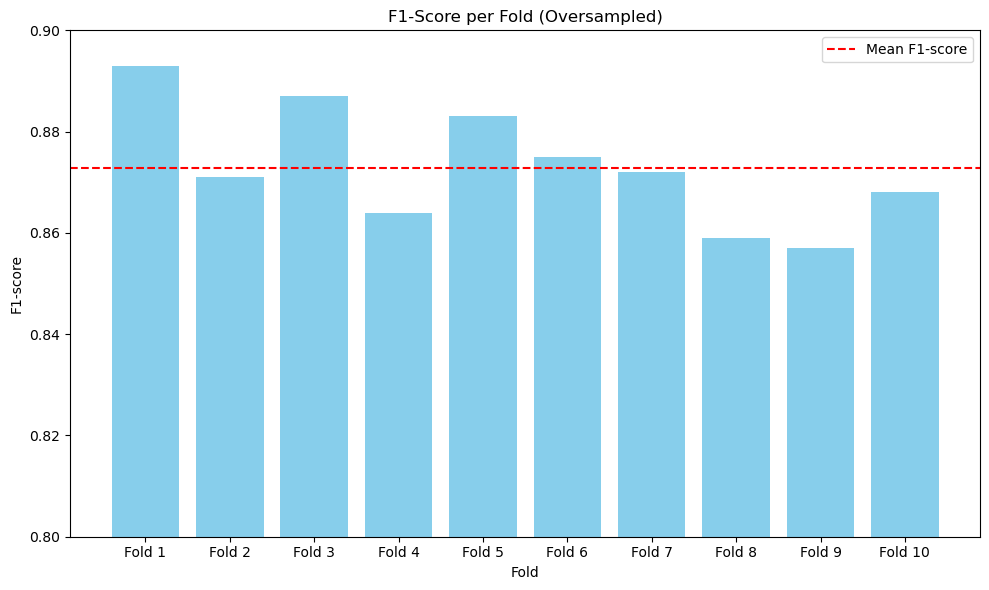

In [11]:
f1_scores = [0.893, 0.871, 0.887, 0.864, 0.883, 0.875, 0.872, 0.859, 0.857, 0.868] # Adjust this 
folds = [f'Fold {i+1}' for i in range(10)]

plt.figure(figsize=(10, 6))
plt.bar(folds, f1_scores, color='skyblue')
plt.axhline(y=sum(f1_scores)/len(f1_scores), color='red', linestyle='--', label='Mean F1-score')
plt.title('F1-Score per Fold (Oversampled)')
plt.xlabel('Fold')
plt.ylabel('F1-score')
plt.ylim(0.8, 0.9)
plt.legend()
plt.tight_layout()
plt.show()

Line plot

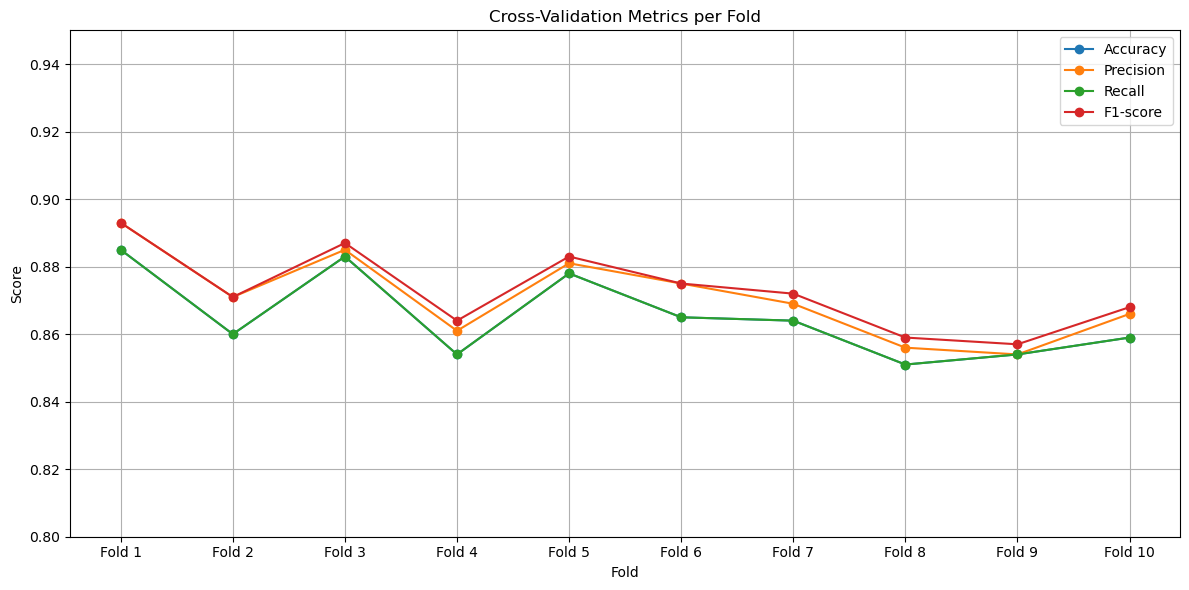

In [12]:
accuracy = [0.885, 0.860, 0.883, 0.854, 0.878, 0.865, 0.864, 0.851, 0.854, 0.859]
precision = [0.893, 0.871, 0.885, 0.861, 0.881, 0.875, 0.869, 0.856, 0.854, 0.866]
recall = [0.885, 0.860, 0.883, 0.854, 0.878, 0.865, 0.864, 0.851, 0.854, 0.859]
f1 = [0.893, 0.871, 0.887, 0.864, 0.883, 0.875, 0.872, 0.859, 0.857, 0.868]

plt.figure(figsize=(12, 6))
plt.plot(folds, accuracy, label='Accuracy', marker='o')
plt.plot(folds, precision, label='Precision', marker='o')
plt.plot(folds, recall, label='Recall', marker='o')
plt.plot(folds, f1, label='F1-score', marker='o')
plt.title('Cross-Validation Metrics per Fold')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.ylim(0.8, 0.95)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Confusion Matrix

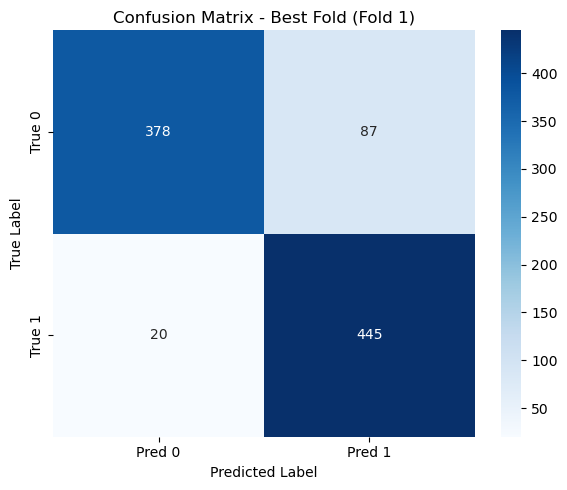

In [ ]:


cm = np.array([[378, 87],
               [20, 445]])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title("Confusion Matrix - Best Fold (Fold 1)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

Box plot

C:\Users\MufliDevs\AppData\Local\Temp\ipykernel_13504\3202717414.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=df_plot, palette='pastel')


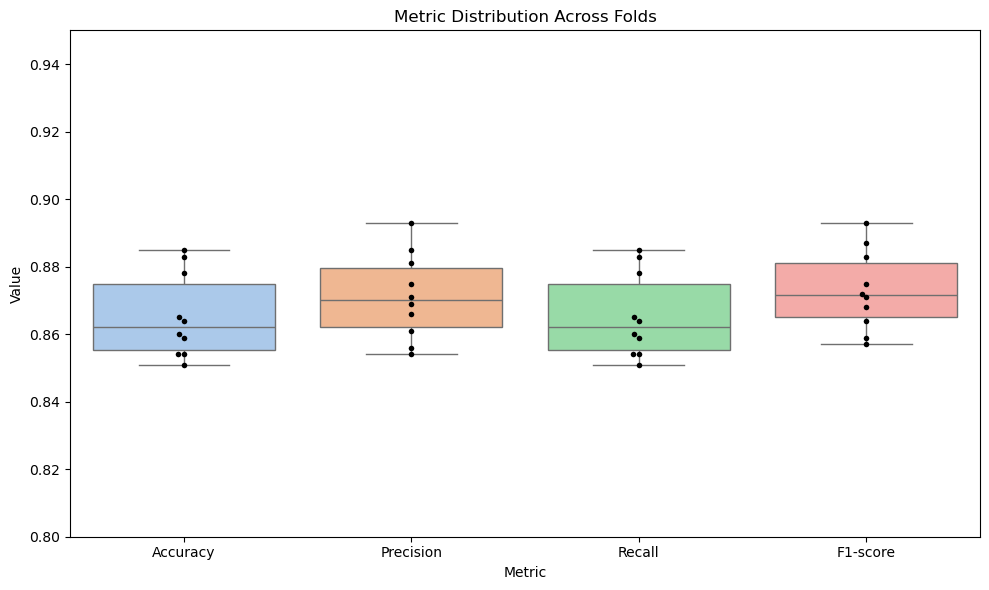

In [15]:

data = {
    'Fold': folds * 4,
    'Metric': ['Accuracy']*10 + ['Precision']*10 + ['Recall']*10 + ['F1-score']*10,
    'Value': accuracy + precision + recall + f1
}

df_plot = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Value', data=df_plot, palette='pastel')
sns.swarmplot(x='Metric', y='Value', data=df_plot, color='black', size=4)
plt.title("Metric Distribution Across Folds")
plt.ylim(0.8, 0.95)
plt.tight_layout()
plt.show()